# Spokane Solar Suitability
### Areeba Usman & Rose Martin
### 
---

## Section 0: Load in data and import packages

In [1]:
!pip install -q censusdata

In [2]:
import os
import shutil
import zipfile
import requests
import censusdata
import rasterstats
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import rasterio as rio
import geopandas as gpd
import rioxarray as rxr
from pathlib import Path
import contextily as ctx
from scipy.ndimage import label
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import xyzservices.providers as xyz
from rasterio.features import rasterize
from rasterio import plot, mask, features
from rasterio.transform import from_origin
from matplotlib_scalebar.scalebar import ScaleBar
from shapely.geometry import Point, Polygon, shape, box
from rasterio.warp import calculate_default_transform, reproject, Resampling

---
## Section 1: Loading Zone
### Census Data

In [3]:
#Functions taken from lab 5
def get_census_data(tables, state, county, year=2019):
    '''Download census data for a given state and county fips code.'''

    # Download the data
    data = censusdata.download('acs5', year,  # Use 2019 ACS 5-year estimates
                               censusdata.censusgeo([('state', state), ('county', county), ('tract', '*')]),
                               list(tables.keys()))

    # Rename the column
    data.rename(columns=tables, inplace=True)

    # Extract information from the first column
    data['Name'] = data.index.to_series().apply(lambda x: x.name)
    data['SummaryLevel'] = data.index.to_series().apply(lambda x: x.sumlevel())
    data['State'] = data.index.to_series().apply(lambda x: x.geo[0][1])
    data['County'] = data.index.to_series().apply(lambda x: x.geo[1][1])
    data['Tract'] = data.index.to_series().apply(lambda x: x.geo[2][1])
    data.reset_index(drop=True, inplace=True)
    data = data[['Tract','Name']+list(tables.values())].set_index('Tract')
    
    return data

def get_census_tract_geom(state_fips, county_fips):
    '''Download census tract geometries for a given state and county fips code, storing in /tmp and cleaning up after.'''

    temp_dir = "/tmp/census_tracts"
    zip_path = os.path.join(temp_dir, f'tl_2019_{state_fips}_tract.zip')

    # Ensure temp directory exists
    os.makedirs(temp_dir, exist_ok=True)

    # Download the file
    url = f'https://www2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_{state_fips}_tract.zip'
    response = requests.get(url, stream=True)
    if response.status_code != 200:
        raise Exception(f"Failed to download file: {url}")

    # Save ZIP file to temp directory
    with open(zip_path, "wb") as file:
        file.write(response.content)

    # Extract the ZIP file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(temp_dir)

    # Find the shapefile in extracted contents
    for file in os.listdir(temp_dir):
        if file.endswith(".shp"):
            shapefile_path = os.path.join(temp_dir, file)
            break

    # Read the shapefile into a GeoDataFrame
    tracts = gpd.read_file(shapefile_path)

    # Filter by county and set index
    tracts = tracts[tracts['COUNTYFP'] == county_fips]
    tracts = tracts.rename(columns={'TRACTCE': 'Tract'}).set_index('Tract')

    # Cleanup: Remove extracted files and ZIP file
    shutil.rmtree(temp_dir)

    return tracts[['geometry']]



In [4]:
tables = {
'B19013_001E': 'MedianIncome',
'B01003_001E': 'TotalPopulation',
'B25064_001E': 'MedianGrossRent',
'B25077_001E': 'MedianHomeValue',
'B25035_001E': 'MedianYearStructureBuilt',
'B25001_001E': 'TotalHousingUnits',
'B25004_001E': 'TotalVacantHousingUnits',
'B25003_002E': 'OccupiedHousingUnitsOwnerOccupied',
'B25003_003E': 'OccupiedHousingUnitsRenterOccupied',
}

In [5]:
## FIPS Code for Washington
state_fips = '53' 

## FIPS code for Spokane County
county_fips = '063'  

In [6]:
census_df = get_census_data(tables, state_fips, county_fips)
tract_geom_gdf = get_census_tract_geom(state_fips, county_fips)
tract_geom_gdf_fo_proj = tract_geom_gdf

In [7]:
census_Spokane_gdf = gpd.GeoDataFrame(census_df.join(tract_geom_gdf))
census_Spokane_gdf =  census_Spokane_gdf.to_crs('epsg:32610')
#census_df.head()

#### AEA Projection around Spokane

In [8]:
hull = tract_geom_gdf_fo_proj.geometry.unary_union.convex_hull
cent = hull.centroid

cent_lon =cent.x
cent_lat = cent.y
min_lat = tract_geom_gdf_fo_proj.bounds["miny"].min().item()
max_lat = tract_geom_gdf_fo_proj.bounds["maxy"].max().item()

/tmp/ipykernel_742/2544106682.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  hull = tract_geom_gdf_fo_proj.geometry.unary_union.convex_hull


In [9]:
proj_str_aea = f'+proj=aea +lat_1={min_lat:0.2f} +lat_2={max_lat:0.2f} +lat_0={cent_lat:0.2f} +lon_0={cent_lon:0.2f}'
print(proj_str_aea)

+proj=aea +lat_1=47.26 +lat_2=48.05 +lat_0=47.64 +lon_0=-117.42


### States

In [10]:
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json'
states_gdf = gpd.read_file(states_url)
states_gdf.head()

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry
0,0400000US23,23,Maine,,30842.923,"MULTIPOLYGON (((-67.61976 44.51975, -67.61541 ..."
1,0400000US25,25,Massachusetts,,7800.058,"MULTIPOLYGON (((-70.83204 41.6065, -70.82374 4..."
2,0400000US26,26,Michigan,,56538.901,"MULTIPOLYGON (((-88.68443 48.11578, -88.67563 ..."
3,0400000US30,30,Montana,,145545.801,"POLYGON ((-104.0577 44.99743, -104.25014 44.99..."
4,0400000US32,32,Nevada,,109781.180,"POLYGON ((-114.0506 37.0004, -114.05 36.95777,..."


In [11]:
## 32048 is the EPSG recommended for Spokane County
states_proj_gdf = states_gdf.to_crs(4326)

WA_idx = states_proj_gdf["NAME"].isin(["Washington"])
wa_state_gdf = states_proj_gdf[WA_idx]

### Flood Plains

In [12]:
floodplains_fn = './Data/FEMA_Flood_Zone.geojson'
floodplains_gdf = gpd.read_file(floodplains_fn)

In [13]:
floodplains_gdf = floodplains_gdf.set_crs(4326)
floodplains_gdf.head()

,OBJECTID,FLD_ZONE,FloodZone,FloodDescription,ShapeSTArea,ShapeSTLength,geometry
0,1,AE,100 Year,1 Percent Annual Chance Flood Zone,2563.373517,1057.303252,"POLYGON ((-117.21347 47.71921, -117.21342 47.7..."
1,2,AE,100 Year,1 Percent Annual Chance Flood Zone,47091.207776,1316.843587,"POLYGON ((-117.39354 47.5726, -117.3937 47.572..."
2,3,X,500 Year,0.2 Percent Annual Chance Flood Zone,12072.635706,1139.022057,"POLYGON ((-117.41693 47.66159, -117.41703 47.6..."
3,4,AE,100 Year,1 Percent Annual Chance Flood Zone,3293.344152,385.964150,"POLYGON ((-117.33046 47.92931, -117.33022 47.9..."
4,5,X,500 Year,0.2 Percent Annual Chance Flood Zone,140930.032756,2078.807675,"POLYGON ((-117.78801 47.42675, -117.78808 47.4..."


#### Binary Flood Plain Raster

In [15]:
# Reproject to projected CRS
floodplains_gdf = floodplains_gdf.to_crs(proj_str_aea)
tract_geom_gdf = tract_geom_gdf.to_crs(proj_str_aea)

# Get bounds of the area of interest
xmin, ymin, xmax, ymax = tract_geom_gdf.total_bounds

# Define the resolution of the raster (in meters)
resolution = 100  # Change as needed
width = int((xmax - xmin) / resolution)
height = int((ymax - ymin) / resolution)

# Define transform for rasterization
transform = from_origin(xmin, ymax, resolution, resolution)

# Create binary raster mask of floodplain areas (value = 0)
shapes_floodplain = [(geom, 0) for geom in floodplains_gdf.geometry]
raster = rasterize(shapes_floodplain, out_shape=(height, width), transform=transform, fill=1, dtype=np.float32)

# Create a 500-meter buffer around floodplain areas
floodplains_gdf["geometry"] = floodplains_gdf.geometry.buffer(500)

# Rasterize the buffered floodplain areas (value = 0.5), but only overwrite areas that are still 1
shapes_buffer = [(geom, 0.5) for geom in floodplains_gdf.geometry]
buffer_raster = rasterize(shapes_buffer, out_shape=(height, width), transform=transform, fill=1, dtype=np.float32)

# Merge rasters: Keep original 0s, overwrite 1s with buffer values (0.5)
raster[(raster == 1) & (buffer_raster == 0.5)] = 0.5

# Save raster to file
with rio.open(
    "./Data/floodplain_with_buffer.tif", "w", driver="GTiff", height=height, width=width,
    count=1, dtype=np.float32, crs=proj_str_aea, transform=transform
) as dst:
    dst.write(raster, 1)


In [16]:
floodplain_buffer_fn = "./Data/floodplain_with_buffer.tif"
floodplain_buffer_data = rxr.open_rasterio(floodplain_buffer_fn).squeeze()

### Slope Data

In [17]:
dst_crs = 'EPSG:32610'

In [18]:
dem_data = f'{Path.home()}/gda_demo_data/dem_data'
dem_fn = os.path.join(dem_data, "WA_COP90.tif")

In [19]:
proj_fn = os.path.splitext(dem_fn)[0]+'_utm_gdalwarp.tif'
slope_fn = os.path.splitext(proj_fn)[0]+'_slope.tif'

In [29]:
!gdaldem slope $proj_fn $slope_fn

0...10...20...30...40...50...60...70...80...90...100 - done.


In [30]:
slope_ras = rxr.open_rasterio(slope_fn, masked=True).squeeze()

### Substation Distance

In [20]:
#This Code was aquired using the help of ChatGPT
# URL of the ArcGIS FeatureServer
url = "https://services6.arcgis.com/OO2s4OoyCZkYJ6oE/arcgis/rest/services/Substations/FeatureServer/0/query"

resolution = 100 

# Define query parameters for the request
params = {
    "where": "COUNTY = 'SPOKANE'",  # Filter for records where the STATE field is 'WA'
    "outFields": "*",  # Fetch all fields
    "f": "geojson"  # Request GeoJSON format
}

# Send the request and get the response
response = requests.get(url, params=params)

# Check if the request was successful
if response.status_code == 200:
    # Load the GeoJSON into a GeoDataFrame
    substation_gdf = gpd.read_file(response.text)

else:
    print(f"Failed to fetch data: {response.status_code}")

In [22]:
# Code aquired from CHAT
substations = substation_gdf

substations = substations.to_crs(epsg=32610)
substations = substations.to_crs(proj_str_aea)
tract_geom_gdf =tract_geom_gdf.to_crs(proj_str_aea)

# Get the bounding box from substations
xmin, ymin, xmax, ymax = tract_geom_gdf.total_bounds

# Define the resolution of the raster (in meters)
resolution = 100  # Change this as needed (e.g., 100 meters per pixel)
width = int((xmax - xmin) / resolution)
height = int((ymax - ymin) / resolution)


raster = np.full((height, width), np.nan, dtype=np.float32)

# Extract coordinates of substations
substation_coords = np.array(list(zip(substations.geometry.x, substations.geometry.y)))

# Create a spatial index using cKDTree for efficient distance computation
tree = cKDTree(substation_coords)

# Compute distances for each pixel
for i in range(height):
    for j in range(width):
        x = xmin + j * resolution + resolution / 2
        y = ymax - i * resolution - resolution / 2
        dist, _ = tree.query((x, y))
        raster[i, j] = dist / 1000  # converts it to km


transform = from_origin(xmin, ymax, resolution, resolution)

# Save raster to file
with rio.open(
    "./Data/distance_raster_proj_alt.tif", "w", driver="GTiff", height=height, width=width,
    count=1, dtype=np.float32, crs=proj_str_aea, transform=transform
) as dst:
    dst.write(raster, 1)

In [23]:
substation_distance_raster_fn = "./Data/distance_raster_proj_alt.tif"
substation_distance_raster_data = rxr.open_rasterio(substation_distance_raster_fn).squeeze()

### Radiation

In [24]:
## Only run once!

radiation_fn = "./Data/radiation.tif"
radiation = rxr.open_rasterio(radiation_fn).squeeze()

### Land Use

In [25]:
land_use_fn = "./Data/land_use.tif"
proj_land_fn = os.path.splitext(land_use_fn)[0]+'_utm_gdalwarp.tif'

In [26]:
dst_crs = 'EPSG:4326'

!gdalwarp -srcnodata 0 -t_srs $dst_crs $land_use_fn $proj_land_fn

Processing ./Data/land_use.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


In [27]:
land_use_da = rxr.open_rasterio(proj_land_fn).squeeze()

---
## Section 2A: Data Prep

### CRS Projection Match to Spokane AEA

In [31]:
slope_ras = slope_ras.rio.reproject(proj_str_aea)

land_use_da = land_use_da.rio.reproject(proj_str_aea)

radiation = radiation.rio.reproject(proj_str_aea)

census_Spokane_gdf = census_Spokane_gdf.to_crs(proj_str_aea)

tract_geom_gdf = tract_geom_gdf.to_crs(proj_str_aea)

floodplains_gdf = floodplains_gdf.to_crs(proj_str_aea)

substation_gdf = substation_gdf.to_crs(proj_str_aea)

census_geom = census_Spokane_gdf.geometry.unary_union

/tmp/ipykernel_742/3430024146.py:15: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  census_geom = census_Spokane_gdf.geometry.unary_union


### Clipping all data to available land in Spokane

In [32]:
slope = slope_ras.rio.clip([census_geom])
land_use = land_use_da.rio.clip([census_geom])
radiation = radiation.rio.clip([census_geom])
substation_distance = substation_distance_raster_data.rio.clip([census_geom])
floodplain_buffer = floodplain_buffer_data.rio.clip([census_geom])

### Matching Resolutions

In [34]:
land_use = land_use_da.rio.reproject_match(floodplain_buffer_data)
radiation = radiation.rio.reproject_match(floodplain_buffer_data)
slope = slope.rio.reproject_match(floodplain_buffer_data)

In [41]:
print(radiation.rio.resolution(), 
      slope.rio.resolution(), 
      land_use.rio.resolution(),
      substation_distance.rio.resolution(),
      floodplain_buffer.rio.resolution())

(100.0, -100.0) (100.0, -100.0) (100.0, -100.0) (100.0, -100.0) (100.0, -100.0)


# Plotting

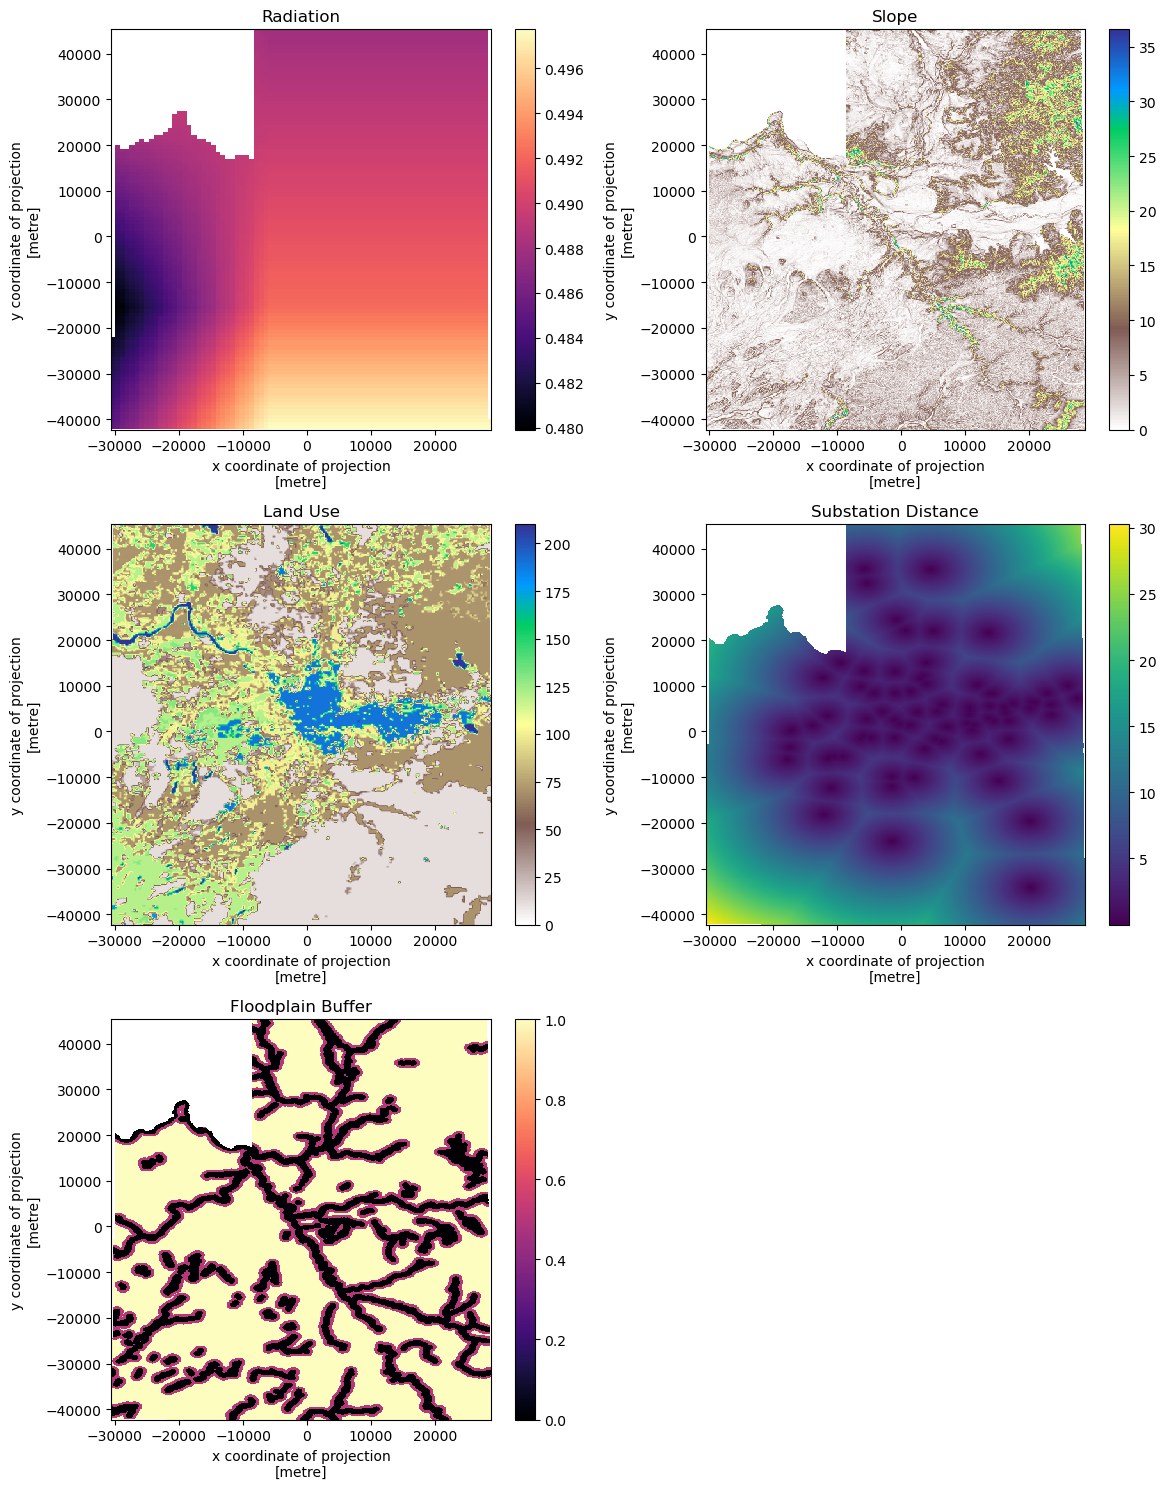

In [54]:
ds = [radiation, slope, land_use, substation_distance, floodplain_buffer]
titles = ['Radiation', 'Slope', 'Land Use', 'Substation Distance', 'Floodplain Buffer']
cmap = ['magma', 'terrain_r', 'terrain_r', 'viridis', 'magma']

n_rows = (len(datasets) + 1) // 2

fig, axs = plt.subplots(n_rows, 2, figsize=(12, n_rows * 5))

# Flatten axs in case there's only one row
axs = axs.flatten()

for i, (data, title, cmap) in enumerate(zip(ds, titles, cmap)):
    data.plot(ax=axs[i], cmap=cmap)
    axs[i].set_title(title)
    axs[i].axis('on')

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

---
## Section 2B: Merging all data to XDarray Datafrane & Summary Table

In [56]:
floodplain_buffer.name = 'Flood_Zones'
substation_distance.name = 'Substation_Distance'
radiation.name = 'Radiation'
land_use.name = 'Land_Use'
slope.name = 'Slope'

In [63]:
merged_df = xr.merge([floodplain_buffer, 
                      slope, 
                      substation_distance, 
                      radiation, 
                      land_use])
merged_df

<xarray.Dataset> Size: 11MB
Dimensions:              (x: 593, y: 876)
Coordinates:
    band                 int64 8B 1
  * x                    (x) float64 5kB -3.05e+04 -3.04e+04 ... 2.87e+04
  * y                    (y) float64 7kB 4.53e+04 4.52e+04 ... -4.22e+04
    spatial_ref          int64 8B 0
Data variables:
    Flood_Zones          (y, x) float32 2MB nan nan nan nan ... 1.0 1.0 1.0 1.0
    Slope                (y, x) float32 2MB nan nan nan ... 1.722 3.648 4.064
    Substation_Distance  (y, x) float32 2MB nan nan nan ... 11.57 11.64 11.71
    Radiation            (y, x) float64 4MB nan nan nan nan ... nan nan nan nan
    Land_Use             (y, x) uint8 519kB 0 0 0 113 69 58 ... 11 11 11 11 11
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

### Summary Table

In [64]:
st = merged_df.mean()
st = merged_df.to_dataframe().describe()
st

,band,spatial_ref,Flood_Zones,Slope,Substation_Distance,Radiation,Land_Use
count,519468.0,519468.0,461258.000000,460998.000000,461258.000000,458396.000000,519468.000000
mean,1.0,0.0,0.712061,4.509359,7.277742,0.490318,67.544268
std,0.0,0.0,0.405179,4.805049,5.613572,0.003321,48.313111
min,1.0,0.0,0.000000,0.000000,0.001652,0.479920,0.000000
25%,1.0,0.0,0.500000,1.239282,2.873534,0.488473,11.000000
50%,1.0,0.0,1.000000,2.764298,5.769769,0.490086,70.000000
75%,1.0,0.0,1.000000,5.866032,10.252606,0.492004,100.000000
max,1.0,0.0,1.000000,36.582905,30.263113,0.497737,210.000000


## Section 3: Classifying & Scaling DF 

In [65]:
scale = merged_df

In [69]:
scale['Land_Use'] = xr.where((scale['Land_Use'] >= 150) & (scale['Land_Use'] <= 180) | (scale['Land_Use'] >= 210), 1, land_classes)  # Water/Snow
scale['Land_Use'] = xr.where((scale['Land_Use'] == 190), 2, land_classes)  # Urban Areas
scale['Land_Use'] = xr.where((scale['Land_Use'] >= 10) & (scale['Land_Use'] <= 20), 3, land_classes)  # Farmland
scale['Land_Use'] = xr.where((scale['Land_Use'] >= 50) & (scale['Land_Use'] <= 90) | (scale['Land_Use'] == 100), 4, land_classes)  # Forests
scale['Land_Use'] = xr.where((scale['Land_Use'] == 200), 5, land_classes)  # Bare Areas
scale['Land_Use'] = xr.where((scale['Land_Use'] == 30) | (scale['Land_Use'] >= 110) & (scale['Land_Use'] <= 140), 6, land_classes) # Grasslands

In [70]:
# Creates the scale for the substation distancce. Based on how far the substation is from each pixel
scale["Flood_Zones"] = merged_df.Flood_Zones * 6
# Always reference original values from merged_df, ensuring that things are not being overwritten in the original
original_values = merged_df["Substation_Distance"]

# Only update values in scale without overwriting previous changes
scale["Substation_Distance"] = xr.where(original_values <= 2.5, 6, scale["Substation_Distance"])
scale["Substation_Distance"] = xr.where((original_values > 2.5) & (original_values <= 5), 5, scale["Substation_Distance"])
scale["Substation_Distance"] = xr.where((original_values > 5) & (original_values <= 7.5), 4, scale["Substation_Distance"])

scale["Substation_Distance"] = xr.where((original_values >= 7.5) & (original_values < 10), 3, scale["Substation_Distance"])
scale["Substation_Distance"] = xr.where((original_values > 10) & (original_values <= 15), 2, scale["Substation_Distance"])
scale["Substation_Distance"] = xr.where((original_values > 15), 1, scale["Substation_Distance"])

In [71]:

original_values = merged_df["Slope"]

# Slope is ranked by the best, 6, being the lowest slopes, and the worst, one being the steepest
scale["Slope"] = xr.where(original_values <= 5, 6, scale["Slope"])
scale["Slope"] = xr.where((original_values > 5) & (original_values <= 10), 5, scale["Slope"])
scale["Slope"] = xr.where((original_values > 10) & (original_values <= 15), 4, scale["Slope"])

#Any slope above 15 too steep and gets a value of one
scale["Slope"] = xr.where(original_values >= 15, 1, scale["Slope"])


In [72]:
min_value = merged_df["Radiation"].min().item()
max_value = merged_df["Radiation"].max().item()
range_values = (max_value - min_value)/ 6

In [73]:
original_values = merged_df["Radiation"]

#Values seperated ransomly as the values are all within range for what is desired from a solar farm

scale["Radiation"] = xr.where((original_values > (max_value-range_values)) & (original_values <= max_value), 6, scale["Radiation"])
scale["Radiation"] = xr.where((original_values > (max_value-range_values*2)) & (original_values <= (max_value - range_values)), 5, scale["Radiation"])
scale["Radiation"] = xr.where((original_values > (max_value - range_values*3)) & (original_values <= (max_value - 2*range_values)), 4, scale["Radiation"])
scale["Radiation"] = xr.where((original_values >= (min_value+ 2* range_values)) & (original_values <= (min_value + 3*range_values)), 3, scale["Radiation"])
scale["Radiation"] = xr.where((original_values >= (min_value+range_values)) & (original_values <= (min_value + 2*range_values)), 2, scale["Radiation"])
scale["Radiation"] = xr.where((original_values >= (min_value)) & (original_values <= (min_value + range_values)), 1, scale["Radiation"])

In [74]:
## removes all the spots that are ether nan or 0 as those are the areas that are either outside the county border 
##    or have been marksed as flood plains. Removes these points from every raster.
scale = scale.where((scale.Flood_Zones.notnull()) & (scale.Flood_Zones != 0), drop=True)

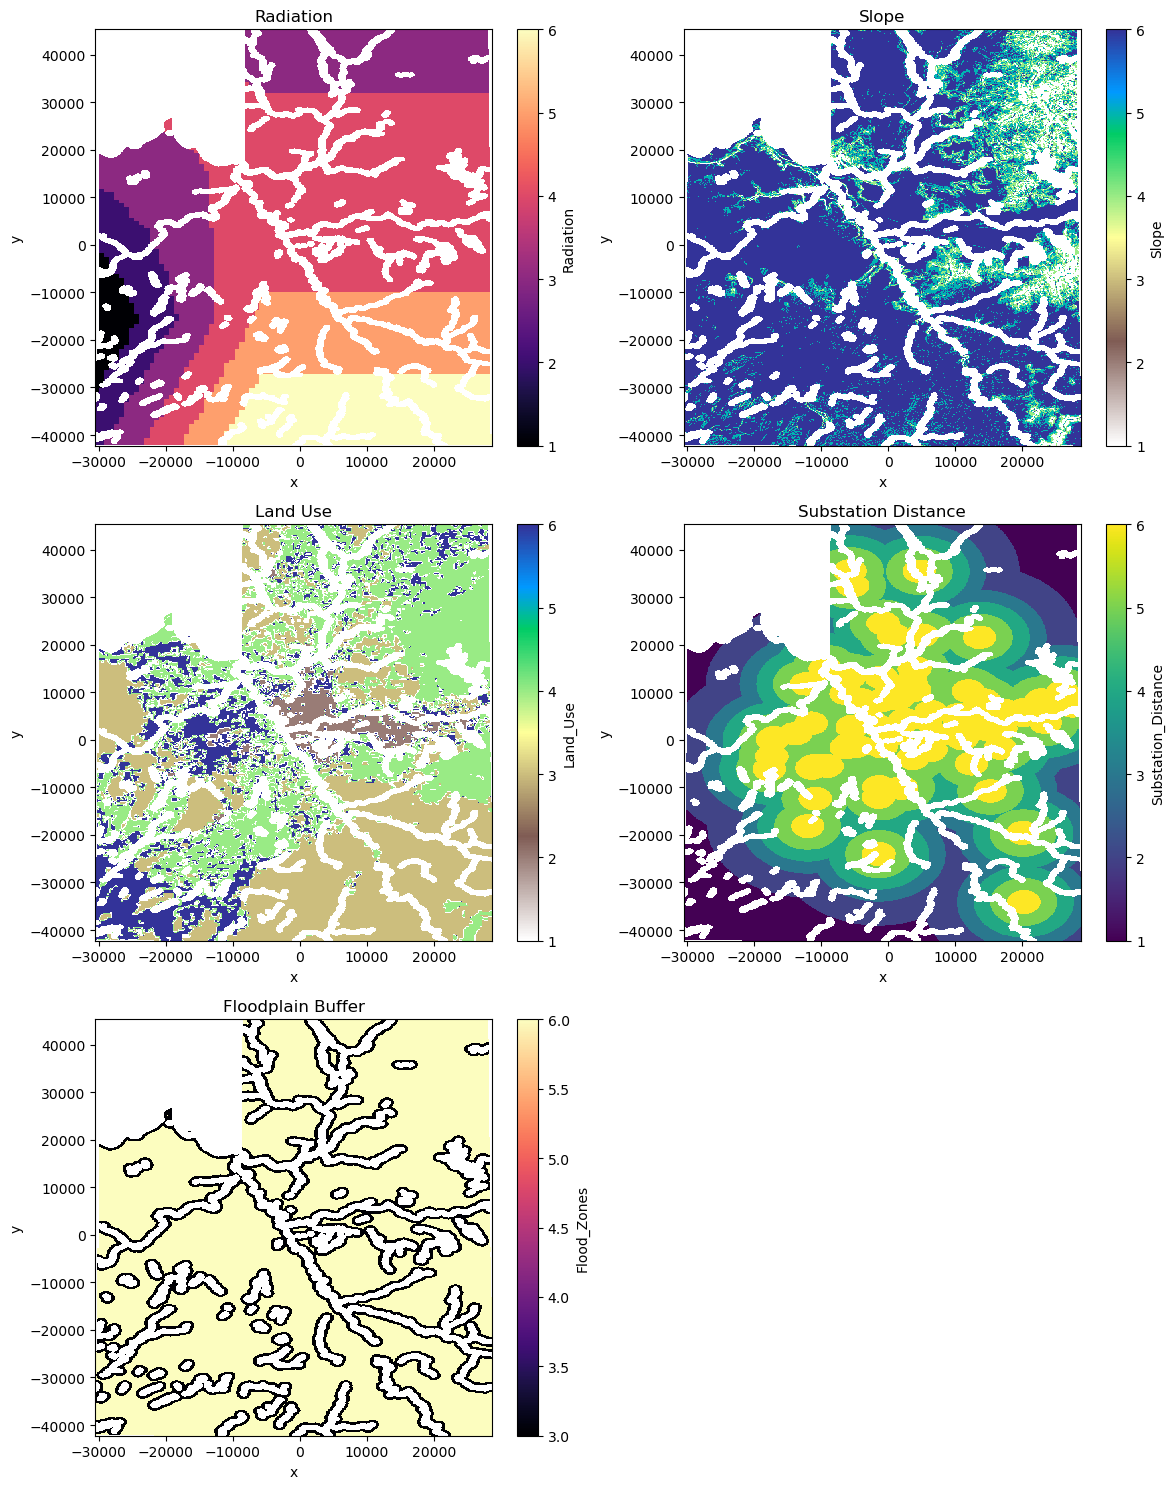

In [75]:
ds = [scale["Radiation"], scale["Slope"], scale["Land_Use"], scale["Substation_Distance"], scale["Flood_Zones"]]
titles = ['Radiation', 'Slope', 'Land Use', 'Substation Distance', 'Floodplain Buffer']
cmap = ['magma', 'terrain_r', 'terrain_r', 'viridis', 'magma']

n_rows = (len(datasets) + 1) // 2

fig, axs = plt.subplots(n_rows, 2, figsize=(12, n_rows * 5))

# Flatten axs in case there's only one row
axs = axs.flatten()

for i, (data, title, cmap) in enumerate(zip(ds, titles, cmap)):
    data.plot(ax=axs[i], cmap=cmap)
    axs[i].set_title(title)
    axs[i].axis('on')

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

## Section 4: Score Weight Calculation

In [76]:
# It was determined that the score would be weighted based on the importance/influence of the variable
# The weight was based on what we thoguht was most important but was also somewhat arbitrary

# score = land use * 1 + substatin distacne * 1 + radiation * 0 .75 + slope * 1.25

net_score_unweighted = scale["Radiation"] + scale["Slope"] + scale["Substation_Distance"] + scale["Flood_Zones"]
net_score_weighted = scale["Radiation"] * 0.75 + scale["Slope"] * 1.25 + scale["Substation_Distance"] * 1 + scale["Flood_Zones"] * 0.25

scale["net_score_weighted"] = net_score_weighted
scale['net_score_unweighted']= net_score_unweighted


<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

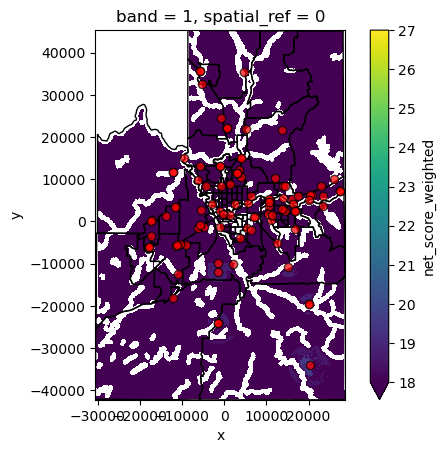

In [77]:
fig,ax = plt.subplots()
scale.net_score_weighted.plot(ax=ax, vmin = 18, vmax= 27)
tract_geom_gdf.plot(ax=ax, edgecolor="black", facecolor = 'none')

substation_gdf.plot(ax=ax, color='red', edgecolor='k',alpha=0.7)


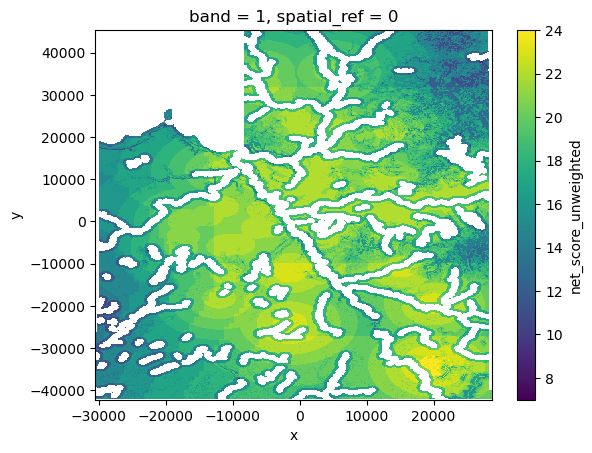

In [78]:
scale.net_score_unweighted.plot()

## Section 5: Finding 200 acre-ft areas

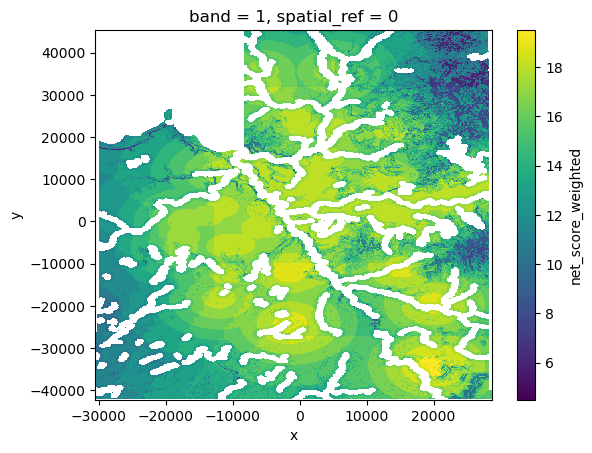

In [90]:
scale_filtered = scale.where((scale["net_score_weighted"] > 22), drop=True)
scale["net_score_weighted"].plot()

In [80]:
scale_filtered

<xarray.Dataset> Size: 16B
Dimensions:               (y: 0, x: 0)
Coordinates:
    band                  int64 8B 1
  * x                     (x) float64 0B 
  * y                     (y) float64 0B 
    spatial_ref           int64 8B 0
Data variables:
    Flood_Zones           (y, x) float32 0B 
    Slope                 (y, x) float32 0B 
    Substation_Distance   (y, x) float32 0B 
    Radiation             (y, x) float64 0B 
    Land_Use              (y, x) float64 0B 
    net_score_weighted    (y, x) float64 0B 
    net_score_unweighted  (y, x) float64 0B 
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [ ]:

ds = scale_filtered

import numpy as np
import xarray as xr
import geopandas as gpd
from shapely.geometry import box, Polygon
from scipy.ndimage import label

# Load your dataset (assuming it's already loaded as 'ds')
# ds = xr.open_dataset("your_dataset.nc")  # Uncomment if loading from a file

# 404686 ft^2 is 100 acres
TARGET_AREA_M2 = 80937.1

# Get spatial resolution
res_x = np.abs(ds.x[1] - ds.x[0])  # Grid cell width
res_y = np.abs(ds.y[1] - ds.y[0])  # Grid cell height
cell_area = res_x * res_y

# Calculate target number of grid cells
target_cells = int(TARGET_AREA_M2 / cell_area)

# Get net score array
net_score = ds.net_score_weighted.values

# Create a binary mask for valid data (exclude NaNs)
binary_mask = np.where(~np.isnan(net_score), 1, 0)

# Label contiguous regions
labeled_array, num_features = label(binary_mask)

# List to store results
results = []

# Iterate through labeled regions
for region_id in range(1, num_features + 1):
    region_mask = labeled_array == region_id
    
    # Check total area
    if np.sum(region_mask) < target_cells:
        continue
    
    # Identify bounding box
    y_indices, x_indices = np.where(region_mask)
    x_min_idx, x_max_idx = np.min(x_indices), np.max(x_indices)
    y_min_idx, y_max_idx = np.min(y_indices), np.max(y_indices)
    
    # Ensure at least 150 pixels wide
    if (x_max_idx - x_min_idx) < 10:
        continue
    
    # Get coordinates
    x_min, x_max = ds.x[x_min_idx].values, ds.x[x_max_idx].values
    y_min, y_max = ds.y[y_max_idx].values, ds.y[y_min_idx].values
    
    # Create geometry
    geom = box(x_min, y_min, x_max, y_max)
    
    # Compute total score
    score = np.nansum(net_score[region_mask])
    
    # Store result
    results.append({"score": score, "geometry": geom})

# Convert results to a GeoDataFrame
gdf = gpd.GeoDataFrame(results, columns=["score", "geometry"], crs=proj_str_aea)  # Adjust CRS as needed


# Print summary
print(gdf.head())


In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
tract_geom_gdf.plot(ax=ax, edgecolor="black", facecolor = 'none')
gdf.plot(column="score", cmap="viridis", edgecolor="black", legend=True, ax=ax)
ax.set_title("Optimal Land Parcels")

In [ ]:
scale_filtered = scale_filtered.rio.reproject(proj_str_aea)

In [ ]:
import numpy as np
import xarray as xr
import geopandas as gpd
from shapely.geometry import box
from scipy.ndimage import label

# Load your dataset (assuming it's already loaded as 'ds')
# ds = xr.open_dataset("your_dataset.nc")  # Uncomment if loading from a file

# Example: scale_filtered is your xarray dataset
ds = scale_filtered

# 80937.1 m^2 is the target area (100 acres)
TARGET_AREA_M2 = 80937.1

# Get spatial resolution
res_x = np.abs(ds.x[1] - ds.x[0])  # Grid cell width in meters
res_y = np.abs(ds.y[1] - ds.y[0])  # Grid cell height in meters
cell_area = res_x * res_y  # Area of each cell in square meters

# Calculate target number of grid cells
target_cells = int(TARGET_AREA_M2 / cell_area)

# Get net score array
net_score = ds.net_score_weighted.values

# Create a binary mask for valid data (exclude NaNs)
binary_mask = np.where(~np.isnan(net_score), 1, 0)

# Label contiguous regions (connected components)
labeled_array, num_features = label(binary_mask)

# List to store results
results = []

# Iterate through labeled regions
for region_id in range(1, num_features + 1):
    region_mask = labeled_array == region_id
    
    # Check total area (number of valid pixels in region)
    if np.sum(region_mask) < target_cells:
        continue
    
    # Identify bounding box (in pixel indices)
    y_indices, x_indices = np.where(region_mask)
    x_min_idx, x_max_idx = np.min(x_indices), np.max(x_indices)
    y_min_idx, y_max_idx = np.min(y_indices), np.max(y_indices)
    
    # Ensure that the region is not too small (e.g., at least 150 pixels wide)
    if (x_max_idx - x_min_idx) < 10:
        continue
    
    # Convert pixel indices to spatial coordinates (in the target CRS)
    x_min, x_max = ds.x[x_min_idx].values, ds.x[x_max_idx].values
    y_min, y_max = ds.y[y_max_idx].values, ds.y[y_min_idx].values
    
    # Create geometry (bounding box for the region)
    geom = box(x_min, y_min, x_max, y_max)
    
    # Compute the total score for this region (sum of net score values in the region)
    score = np.nansum(net_score[region_mask])
    
    # Store the result
    results.append({"score": score, "geometry": geom})


gdf = gpd.GeoDataFrame(results, columns=["score", "geometry"], crs=4326)  # Adjust CRS as needed

# Print summary
print(gdf.head())


In [ ]:
# Plot the parcels
#gdf = gdf.to_crs(proj_str_aea)
ax = gdf.plot(column="score", cmap="viridis", edgecolor="black", legend=True)
ax.set_aspect('equal')  # Fix aspect ratio to be equal
plt.show()

In [ ]:

ds = scale_filtered


import numpy as np
import xarray as xr
import geopandas as gpd
from shapely.geometry import box

# Load your dataset (assuming it's already loaded as 'ds')
# ds = xr.open_dataset("your_dataset.nc")  # Uncomment if loading from a file

# Convert 200 acres to square meters
TARGET_AREA_M2 = 809372

# Get spatial resolution
res_x = np.abs(ds.x[1] - ds.x[0])  # Grid cell width
res_y = np.abs(ds.y[1] - ds.y[0])  # Grid cell height
cell_area = res_x * res_y

# Calculate target number of grid cells
target_cells = int(TARGET_AREA_M2 / cell_area)

# Possible aspect ratios (width, height)
aspect_ratios = [(1, 1), (2, 1), (1, 2), (4, 1), (1, 4)]  # Can be adjusted

# Get net score array
net_score = ds.net_score_weighted.values

# List to store results
results = []

# Iterate over aspect ratios
for w_ratio, h_ratio in aspect_ratios:
    width_cells = int(np.sqrt(target_cells * w_ratio / h_ratio))
    height_cells = int(target_cells / width_cells)
    
    # Ensure valid size
    if width_cells <= 0 or height_cells <= 0:
        continue
    
    # Sliding window search
    for i in range(net_score.shape[0] - height_cells + 1):
        for j in range(net_score.shape[1] - width_cells + 1):
            
            # Extract rectangle and compute score
            score = np.nansum(net_score[i:i+height_cells, j:j+width_cells])
            
            # Ensure indices are within bounds
            x_max_idx = min(j + width_cells, len(ds.x) - 1)
            y_max_idx = min(i + height_cells, len(ds.y) - 1)
            
            # Get coordinates safely
            x_min, x_max = ds.x[j].values, ds.x[x_max_idx].values
            y_min, y_max = ds.y[y_max_idx].values, ds.y[i].values
            
            # Create geometry
            geom = box(x_min, y_min, x_max, y_max)
            
            # Store result
            results.append({"score": score, "geometry": geom})

# Convert results to a GeoDataFrame
gdf = gpd.GeoDataFrame(results, columns=["score", "geometry"], crs="EPSG:4326")  # Adjust CRS as needed

# Print summary
print(gdf.head())